## Ergotropy

The goal of this notebook is to compute the ergotropy $W$ of a system $S$, given an arbitrary initial state and hamiltonian $H$. The ergotropy $W$ is none other that the maximum amount of work extractable from a finite system, and it is given by

$$
W = E(\rho_0) - E(\rho(\tau)) = tr[\rho_0 H] - tr[\rho(\tau) H] = \sum_{j,k}r_j\epsilon_k(|\langle r_j|\epsilon_k \rangle|^2-\delta_{jk})
$$

where we wrote 

$$
\rho_0 = \sum_{j \geqslant 1}r_j|r_j\rangle \langle r_j| \\
H = \sum_{k \geqslant 1}\epsilon_k|\epsilon_k\rangle \langle \epsilon_k| \\
\rho(\tau) = \sum_{j}r_j|\epsilon_j\rangle \langle \epsilon_j|
$$ 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cmath
from IPython.display import Image
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, variance, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, sigmam, sigmap, tensor, thermal_dm, lindblad_dissipator)

%matplotlib inline

## Master equations solutions
In the following we compare our numerical solutions (obtained via `mesolve`) with the analytical solutions of the article. First we consider the state of the battery and of the charger as harmonic oscillators, and then as qubits. 
We are going to compare the plots of the mean energy $E_B(\tau)$ and of the ergotropy $\epsilon_B(\tau)$, defined as:

$$
E_B(\tau) \equiv tr[H_B \rho_B(\tau)] \\
\epsilon_B(\tau) \equiv tr[H_B \rho_B(\tau)] - \min_{U_B} tr[H_B U_B \rho_B(\tau) U_B\dagger ]
$$

In [8]:
# Define some constants
w_zero = 5.
g = 0.2 * w_zero
gtlist = np.linspace(0, g*100, 10000)

In [3]:
# hamiltonian of B
b_B = destroy(n_modes)
H_B = w_zero * b_B.dag() * b_B

In [4]:
# define the analytical results for Energy and Ergotropy
def E_B_theory_only_T(_w_zero, _gamma, _g, _N_B, _t):
    eps = cmath.sqrt(_gamma**2 - (4*_g)**2)
    return _w_zero*_N_B*( 1 + (np.exp(-0.5*_gamma*_t)/(eps**2))*(
        16*_g**2 - _gamma*eps*np.sinh(eps*_t*0.5) - _gamma**2 * np.cosh(eps*_t*0.5)) )

def E_B_theory_only_F(_w_zero, _gamma, _g, _F, _t):
    eps = cmath.sqrt(_gamma**2 - (4*_g)**2)
    return ( (w_zero*_F**2) / (_g**2) ) * (1 - np.exp(-_gamma*_t*0.25)*( 
        np.cosh(eps*_t*0.25) + (_gamma/eps) * np.sinh(eps*_t*0.25) ) )**2

def Ergotropy_B_theory(_w_zero, _rho):
    _D = (1 + 2*expect(b_B.dag()*b_B, _rho) - 2*abs(expect(b_B,_rho))**2)**2 - 4*abs(
        variance(b_B,_rho))**2
    return _w_zero*(expect(b_B.dag()*b_B, _rho) - (cmath.sqrt(_D)-1)/2)

In [16]:
E_B_numeric_both = np.loadtxt("../outputs/results_energytransferforqb/energy_both_underdamped.dat")
E_B_numeric_only_T = np.loadtxt("../outputs/results_energytransferforqb/energy_only_T_underdamped.dat")
E_B_numeric_only_F = np.loadtxt("../outputs/results_energytransferforqb/energy_only_F_underdamped.dat")

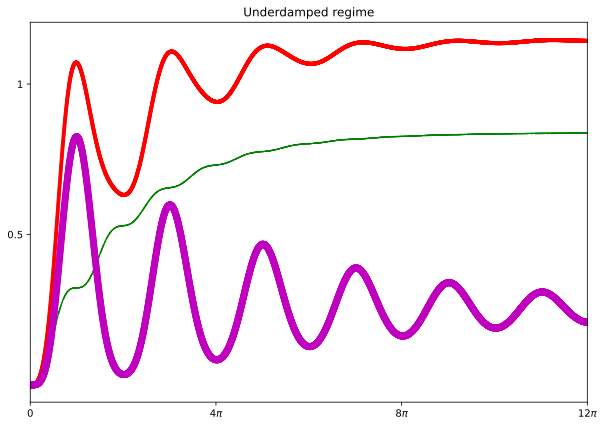

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_both, '.--r', gtlist, E_B_numeric_only_T, ',-.g', gtlist, E_B_numeric_only_F, 'o:m')
ax.set_xlim(0, 12*np.pi)
ax.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_title("Underdamped regime")
plt.show()

In [18]:
ergotropy_B_both = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_both_underdamped.dat")

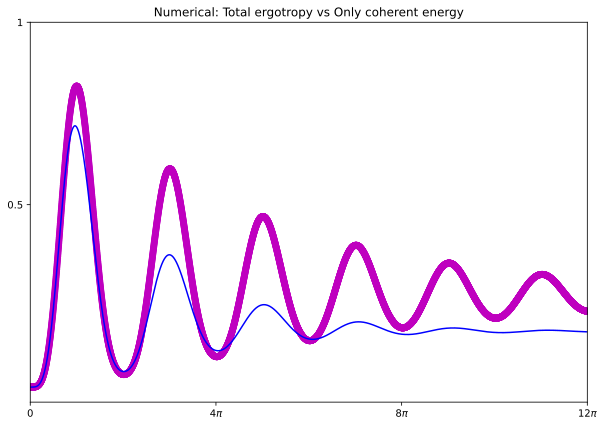

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_only_F, 'o:m', gtlist, ergotropy_B_both, '-b')
ax.set_xlim(0, 12*np.pi)
ax.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_title("Numerical: Total ergotropy vs Only coherent energy") #they should be superimposed!!
plt.show()

In [20]:
F = 0.1 * w_zero
N_B = 1.0 # this is the bosonic occupation number, it should depends on T, but we always choose a value for it
gamma = 0.05 * w_zero

E_B_theory_only_F_underdamped = [ E_B_theory_only_F(w_zero,gamma,g,F,t) / w_zero for t in gtlist ]
E_B_theory_only_T_underdamped = [ E_B_theory_only_T(w_zero,gamma,g,N_B,t) / w_zero for t in gtlist ]
E_B_theory_both_underdamped = [ E_B_theory_only_F_underdamped[i] + E_B_theory_only_T_underdamped[i] for i in range(len(E_B_theory_only_F_underdamped))]

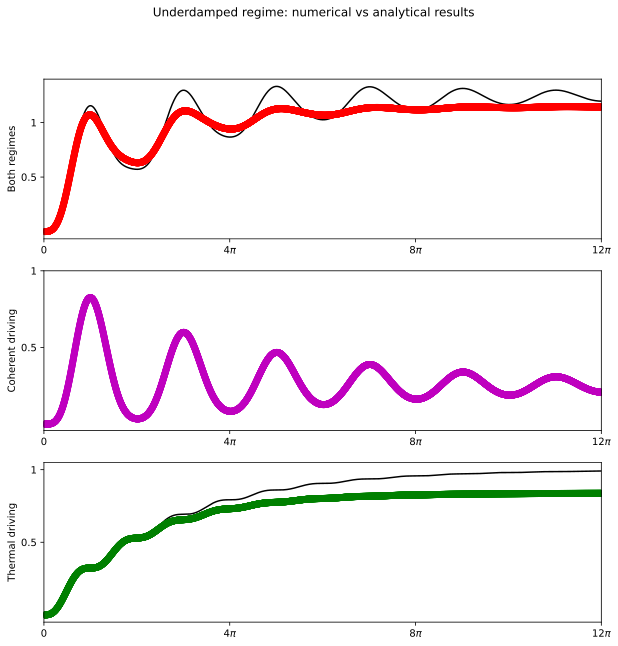

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle("Underdamped regime: numerical vs analytical results")
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(gtlist, E_B_theory_both_underdamped, '-k', gtlist, E_B_numeric_both, 'or')
ax1.set_ylabel("Both regimes")
ax1.set_xlim(0, 12*np.pi)
ax1.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax1.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

ax2.plot(gtlist, E_B_theory_only_F_underdamped, '-k', gtlist, E_B_numeric_only_F, 'om')
ax2.set_ylabel("Coherent driving")
ax2.set_xlim(0, 12*np.pi)
ax2.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax2.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

ax3.plot(gtlist, E_B_theory_only_T_underdamped, '-k', gtlist, E_B_numeric_only_T, 'og')
ax3.set_ylabel("Thermal driving")
ax3.set_xlim(0, 12*np.pi)
ax3.set_xticks([0., 4*np.pi, 8*np.pi, 12*np.pi],
               labels=["$0$", r"$4\pi$", r"$8\pi$", r"$12\pi$"])
ax3.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

In [22]:
E_B_numeric_both_overdamped = np.loadtxt("../outputs/results_energytransferforqb/energy_both_overdamped.dat")
E_B_numeric_only_T_overdamped = np.loadtxt("../outputs/results_energytransferforqb/energy_only_T_overdamped.dat")
E_B_numeric_only_F_overdamped = np.loadtxt("../outputs/results_energytransferforqb/energy_only_F_overdamped.dat")

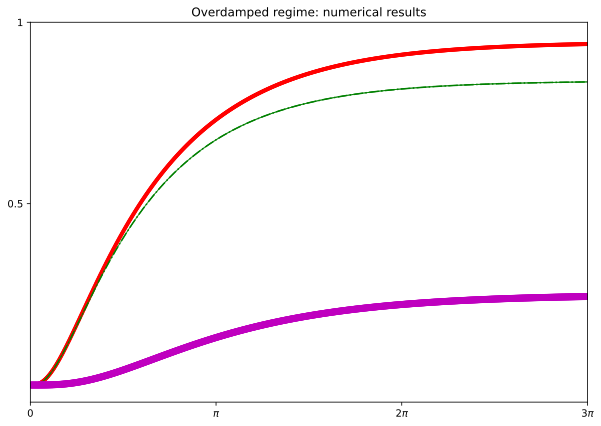

In [23]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_both_overdamped, '.--r', gtlist, E_B_numeric_only_T_overdamped, ',-.g', 
         gtlist, E_B_numeric_only_F_overdamped, 'o:m')
ax.set_title("Overdamped regime: numerical results")
ax.set_xlim(0, 3*np.pi)
ax.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

In [24]:
ergotropy_B_both_overdamped = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_both_overdamped.dat")

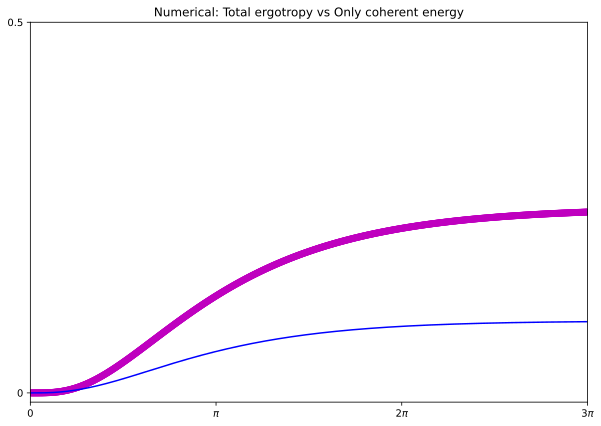

In [25]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_only_F_overdamped, 'o:m', gtlist, ergotropy_B_both_overdamped, '-b')
ax.set_title("Numerical: Total ergotropy vs Only coherent energy") #they should be superimposed!!
ax.set_xlim(0, 3*np.pi)
ax.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax.set_yticks([0., 0.5], labels=["$0$", "$0.5$"])

plt.show()

In [26]:
F = 0.1 * w_zero
gamma = w_zero
N_B = 1.0

E_B_theory_only_F_overdamped = [ E_B_theory_only_F(w_zero,gamma,g,F,t) / w_zero for t in gtlist ]
E_B_theory_only_T_overdamped = [ E_B_theory_only_T(w_zero,gamma,g,N_B,t) / w_zero for t in gtlist ]
E_B_theory_both_overdamped = [ E_B_theory_only_F_overdamped[i] + E_B_theory_only_T_overdamped[i] 
                              for i in range(len(E_B_theory_only_F_overdamped))]

/home/simone/.local/opt/miniconda3/envs/tesi/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


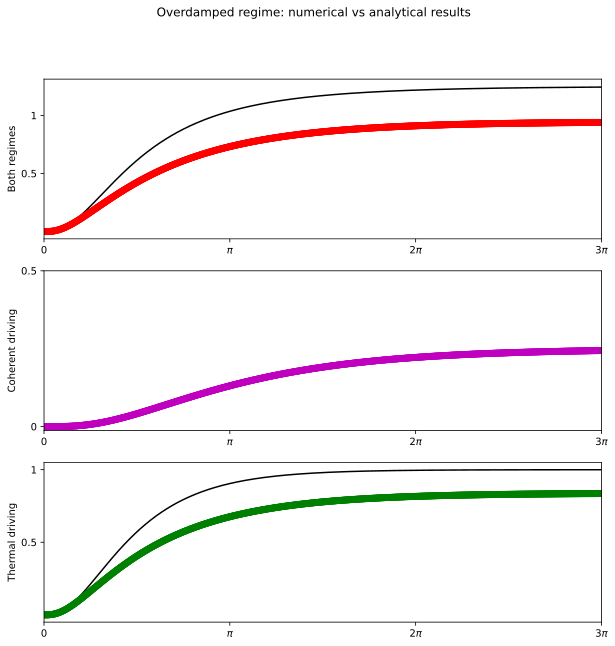

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle("Overdamped regime: numerical vs analytical results")
fig.set_figheight(10)
fig.set_figwidth(10)

ax1.plot(gtlist, E_B_theory_both_overdamped, '-k', gtlist, E_B_numeric_both_overdamped, 'or')
ax1.set_ylabel("Both regimes")
ax1.set_xlim(0, 3*np.pi)
ax1.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax1.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

ax2.plot(gtlist, E_B_theory_only_F_overdamped, '-k', gtlist, E_B_numeric_only_F_overdamped, 'om')
ax2.set_ylabel("Coherent driving")
ax2.set_xlim(0, 3*np.pi)
ax2.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax2.set_yticks([0., 0.5], labels=["$0$", "$0.5$"])

ax3.plot(gtlist, E_B_theory_only_T_overdamped, '-k', gtlist, E_B_numeric_only_T_overdamped, 'og')
ax3.set_ylabel("Thermal driving")
ax3.set_xlim(0, 3*np.pi)
ax3.set_xticks([0., np.pi, 2*np.pi, 3*np.pi],
               labels=["$0$", r"$\pi$", r"$2\pi$", r"$3\pi$"])
ax3.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])

plt.show()

In [24]:
# Two qubit case
w_zero = 5.
g = 0.2 * w_zero
H_B = (w_zero*0.5) * (sigmaz() + 1)

In [28]:
E_B_numeric_F_005 = np.loadtxt("../outputs/results_energytransferforqb/energy_F_005_underdamped.dat")
E_B_numeric_F_02 = np.loadtxt("../outputs/results_energytransferforqb/energy_F_02_underdamped.dat")
E_B_numeric_F_1 = np.loadtxt("../outputs/results_energytransferforqb/energy_F_1_underdamped.dat")

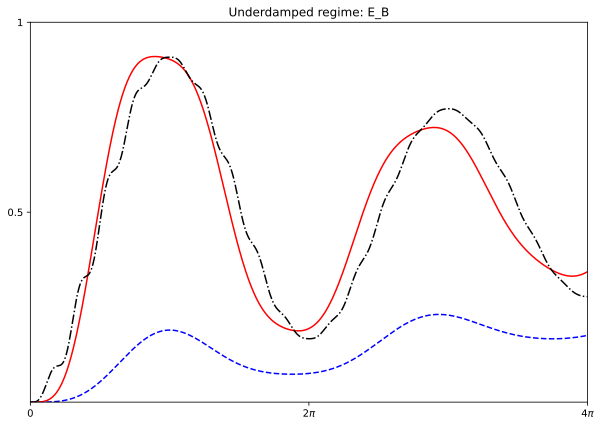

In [29]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_F_005, '--b', gtlist, E_B_numeric_F_02, '-r', gtlist, E_B_numeric_F_1, '-.k')
ax.set_title("Underdamped regime: E_B")
ax.set_xlim(0, 4*np.pi)
ax.set_xticks([0., 2*np.pi, 4*np.pi], labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_ylim(0, 1)

plt.show()

In [30]:
ergotropy_B_F_005 = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_F_005_underdamped.dat")
ergotropy_B_F_02 = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_F_02_underdamped.dat")
ergotropy_B_F_1 = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_F_1_underdamped.dat")

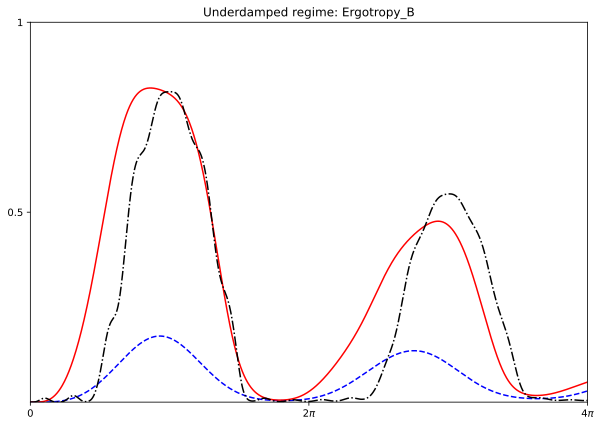

In [31]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_F_005, '--b', gtlist, ergotropy_B_F_02, '-r', gtlist, ergotropy_B_F_1, '-.k')
ax.set_title("Underdamped regime: Ergotropy_B")
ax.set_xlim(0, 4*np.pi)
ax.set_xticks([0., 2*np.pi, 4*np.pi], labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_ylim(0, 1)

plt.show()

In [32]:
E_B_numeric_F_005_over = np.loadtxt("../outputs/results_energytransferforqb/energy_F_005_overdamped.dat")
E_B_numeric_F_02_over = np.loadtxt("../outputs/results_energytransferforqb/energy_F_02_overdamped.dat")
E_B_numeric_F_1_over = np.loadtxt("../outputs/results_energytransferforqb/energy_F_1_overdamped.dat")

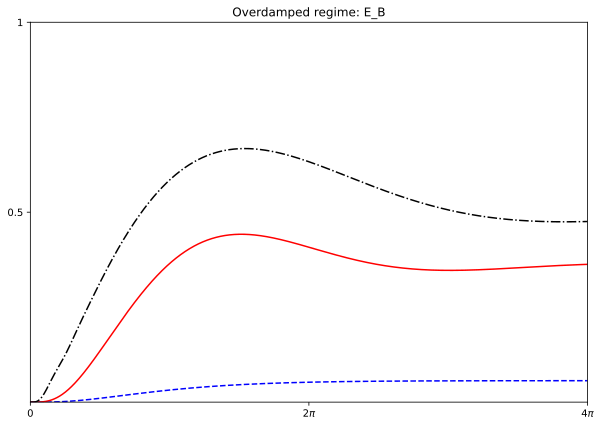

In [33]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, E_B_numeric_F_005_over, '--b', gtlist, E_B_numeric_F_02_over, '-r', gtlist, E_B_numeric_F_1_over, '-.k')
ax.set_title("Overdamped regime: E_B")
ax.set_xlim(0, 4*np.pi)
ax.set_xticks([0., 2*np.pi, 4*np.pi], labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_ylim(0, 1)

plt.show()

In [34]:
ergotropy_B_F_005_over = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_F_005_overdamped.dat")
ergotropy_B_F_02_over = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_F_02_overdamped.dat")
ergotropy_B_F_1_over = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_F_1_overdamped.dat")

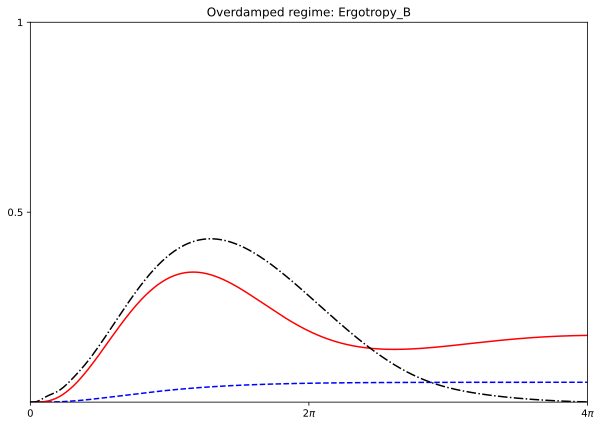

In [35]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_F_005_over, '--b', gtlist, ergotropy_B_F_02_over, '-r', gtlist, ergotropy_B_F_1_over, '-.k')
ax.set_title("Overdamped regime: Ergotropy_B")
ax.set_xlim(0, 4*np.pi)
ax.set_xticks([0., 2*np.pi, 4*np.pi], labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.5, 1], labels=["$0.5$", "$1$"])
ax.set_ylim(0, 1)

plt.show()

In [36]:
# Calculate ergotropy for different values of N_B(T)

# Constants
F = g
gamma = w_zero

In [37]:
ergotropy_B_NB_01_over = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_N_B_01_overdamped.dat")
ergotropy_B_NB_05_over = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_N_B_05_overdamped.dat")
ergotropy_B_NB_1_over = np.loadtxt("../outputs/results_energytransferforqb/ergotropy_N_B_1_overdamped.dat")

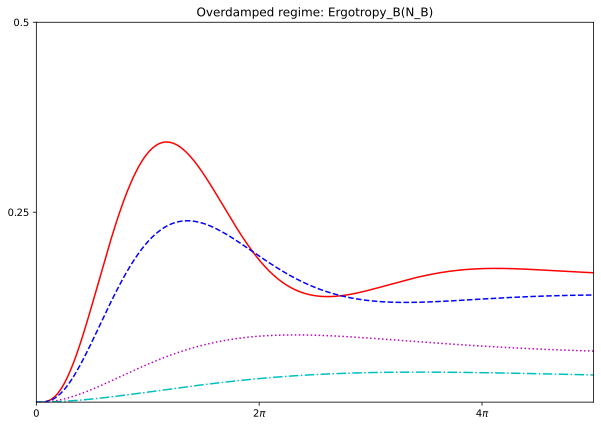

In [38]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot(gtlist, ergotropy_B_F_02_over, '-r', gtlist, ergotropy_B_NB_01_over, '--b', 
       gtlist, ergotropy_B_NB_05_over, ':m', gtlist, ergotropy_B_NB_1_over, '-.c' )
ax.set_title("Overdamped regime: Ergotropy_B(N_B)")
ax.set_xlim(0, 5*np.pi)
ax.set_xticks([0., 2*np.pi, 4*np.pi], labels=["$0$", r"$2\pi$", r"$4\pi$"])
ax.set_yticks([0.25, 0.5], labels=["$0.25$", "$0.5$"])
ax.set_ylim(0, 0.5)

plt.show()